<a href="https://colab.research.google.com/github/eric1645/3-2/blob/main/1_airfoils_design_basic_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The aim of this notebook is to introduce the airfoil use case in order to:

- familiarize the participants with the use case
- facilitate their comprehension
- provide some tools to vizualize/manipulate the use case data

For more details about the dataset itself, that this notebook partially covers, we refer to the [AirfRANS ReadTheDocs](https://airfrans.readthedocs.io/en/latest/index.html)

The AirfRANS dataset was originally created for the publication AIRFRANS: High Fidelity Computational Fluid Dynamics Dataset for Approximating Reynolds-Averaged-Navier-Stokes Solutions (36th Conference on Neural Information Processing Systems (NeurIPS 2022)).

It consists of 1000 computational fluid dynamics (CFD) simulations of steady-state aerodynamics over two dimensions (2D) airfoils in a subsonic flight regime, splitted in different tasks. More precisely, it contains numerical resolutions of the incompressible Reynolds-Averaged Navier–Stokes (RANS) equations over the NACA 4 and 5 digits series of airfoils and in a subsonic flight regime setup.

Those equations are solved using an open-source well-known CFD simulator called [OpenFOAM](https://www.openfoam.com/). The underlying theory for solving this problem and the instantiation of this solver in order to generate data is way beyond the scope of this notebook and as such is not covered. Note that such a resolution can be extremely computationaly expensive, thus there is a need to hybridize in order to find an acceptable compromise between accuracy and computational time.

Regarding the raw data, each simulation is given as a point cloud defined as the nodes of the simulation mesh, that is to say a discretization of the 2D domain. Such a discretization is required to compute the ground truth solution through a classical CFD physical simulator.
Each point of a point cloud is described via 5 features:

* the inlet velocity (two components in meter per second)
* the distance to the airfoil (one component in meter)
* the normals (two components in meter, set to 0 if the point is not on the airfoil).

Each point is given a target of 4 components for the underyling regression task:

* the velocity (two components in meter per second)
* the pressure divided by the specific mass (one component in meter squared per second squared)
* the turbulent kinematic viscosity (one component in meter squared per second)
  
Finally, a boolean is attached to each point to inform if this point lies on the airfoil or not.a boolean is attached to each point to inform if this point lies on the airfoil or not.

### Prerequisites

Install the AirfRANS package

In [ ]:
pip install airfrans

# Retrieve the data

First, we download the data, using the `airfrans` library

In [ ]:
# 1️⃣ Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

# 2️⃣ 필요한 라이브러리 설치
#!pip install airfrans --quiet

# 3️⃣ 모듈 임포트
import os
import airfrans as af

# 4️⃣ Google Drive 내 저장 경로 설정
# 원하는 경로로 수정 가능 (예: 'MyDrive/CFD_Data' 등)
drive_path = '/content/drive/MyDrive/CFD_Dataset'
directory_name = os.path.join(drive_path, 'Dataset')

# 5️⃣ 폴더가 없으면 생성 후 데이터 다운로드
if not os.path.isdir(directory_name):
    os.makedirs(drive_path, exist_ok=True)
    af.dataset.download(
        root=drive_path,         # 다운로드 루트 디렉터리
        file_name='Dataset',     # 폴더 이름
        unzip=True,              # 압축 해제
        OpenFOAM=False           # OpenFOAM 파일 제외
    )

# 6️⃣ 확인
print("✅ Dataset successfully downloaded to Google Drive!")
print("📂 Directory:", directory_name)
print("📁 Files:", os.listdir(directory_name))


Mounted at /content/drive


Extracting Dataset.zip at /content/drive/MyDrive/CFD_Dataset...
✅ Dataset successfully downloaded to Google Drive!
📂 Directory: /content/drive/MyDrive/CFD_Dataset/Dataset
📁 Files: ['airFoil2D_SST_31.803_7.291_3.243_6.962_0.0_10.641', 'airFoil2D_SST_84.572_-2.053_5.842_6.436_6.457', 'airFoil2D_SST_61.863_-0.567_0.289_7.872_0.0_6.693', 'airFoil2D_SST_91.532_9.129_2.77_4.013_1.0_17.265', 'airFoil2D_SST_47.087_4.316_3.699_3.87_7.915', 'airFoil2D_SST_56.3_12.327_1.959_6.913_0.0_15.094', 'airFoil2D_SST_80.985_6.877_2.735_4.998_9.345', 'airFoil2D_SST_80.1_10.905_3.705_2.479_18.371', 'airFoil2D_SST_92.121_3.155_1.986_5.337_10.487', 'airFoil2D_SST_38.802_5.507_3.497_7.184_1.0_10.971', 'airFoil2D_SST_64.541_-1.194_0.524_2.116_5.877', 'airFoil2D_SST_86.895_10.755_1.229_3.979_1.0_9.331', 'airFoil2D_SST_41.311_-3.941_2.322_4.945_6.189', 'airFoil2D_SST_42.847_13.708_0.655_3.944_0.0_7.77', 'airFoil2D_SST_39.497_-4.94_0.473_3.219_1.0_16.447', 'airFoil2D_SST_89.65_8.631_3.032_3.437_0.0_6.8', 'airFoil2D

Next, we load the data, there are four tasks defines as followed:

- Full data regime: 800 simulations are used for the training and 200 are kept for testing. Both the trainset and the testset are drawn from the same distribution. This defines an interpolation task.
- Scarce data regime: Same testset as the Full data regime task but with only 200 simulations in the trainset. This also defines an interpolation task but in a low data regime scenario.
- Reynolds extrapolation regime: Simulations with Reynolds number between 3 and 5 million are kept for the trainset, the others are kept for the testset. This defines an extrapolation task for the reynolds number parameter.
- Angle of attack extrapolation regime: Simulations with angle of attack between -2.5° and 12.5° are kept for the trainset, the others are kept for the testset. This defines an extrapolation task for the angle of attack parameter.

We arbitrarily chose to consider the scarce task. It loads the data on disk associated to the task and return both the simulation names and raw data for each quantity (features and outputs described earlier).

In [ ]:
dataset_list, dataset_name = af.dataset.load(root = directory_name, task = 'scarce', train = True)

Loading dataset (task: scarce, split: train): 100%|██████████| 200/200 [04:08<00:00,  1.24s/it]


# Simulation data manipulation

Each simulation is defined via boundary conditions (inlet velocity and angle of attack) and a geometry (NACA 4 or 5 digits) and the name of a simulation gives all the information about the boundary conditions used to generate it. From the name of the first simulation, we can infer the following information:

In [ ]:
first_simulation_name = dataset_name[100]
print("First simulation name: ",first_simulation_name)
simulation_name_splitted = first_simulation_name.split("_")
print("\t Inlet velocity magnitude:", simulation_name_splitted[2])
print("\t Angle of attack:", simulation_name_splitted[3])
if len(simulation_name_splitted)==7:
    print("\t Airfoil description from NACA 4 digits series:", simulation_name_splitted[4:])
elif len(simulation_name_splitted)==8:
    print("\t Airfoil description from NACA 5 digits series:", simulation_name_splitted[4:])


First simulation name:  airFoil2D_SST_84.367_14.837_0.843_4.812_12.138
	 Inlet velocity magnitude: 84.367
	 Angle of attack: 14.837
	 Airfoil description from NACA 4 digits series: ['0.843', '4.812', '12.138']


At this point, the simulation can be loaded as follows, with a kinematic viscosity at 298.15K

In [ ]:
simulation = af.Simulation(root = directory_name, name = first_simulation_name, T = 298.15)
print(simulation)

Now, by relying on the existing attributes of the `airfrans.Simulation` class, we can vizualize the data for the corresponding simulation.

Namely, we use fields that are either defined on the mesh nodes or on the airfoil patch nodes directly:

- `airfrans.Simulation.position`  is the position of the nodes of the internal mesh
- `airfrans.Simulation.airfoil_position` is the position of the nodes of the airfoil mesh
- `airfrans.Simulation.velocity` is the air velocity on the internal mesh
- `airfrans.Simulation.pressure` is the air pressure on the internal mesh
- `airfrans.Simulation.input_velocity` is the inlet velocity copied on each nodes of the internal mesh
- `airfrans.Simulation.sdf` is the distance function on the internal mesh
- `airfrans.Simulation.nu_t` is the kinematic turbulent viscosity on the internal mesh
- `airfrans.Simulation.normals` is the inward-pointing normals of the surface on the internal mesh, it is set to 0 for points not lying on the airfoil

Now, we are in position to vizualize the features for this simulation, namely the inlet velocity, the distance and the normals.

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

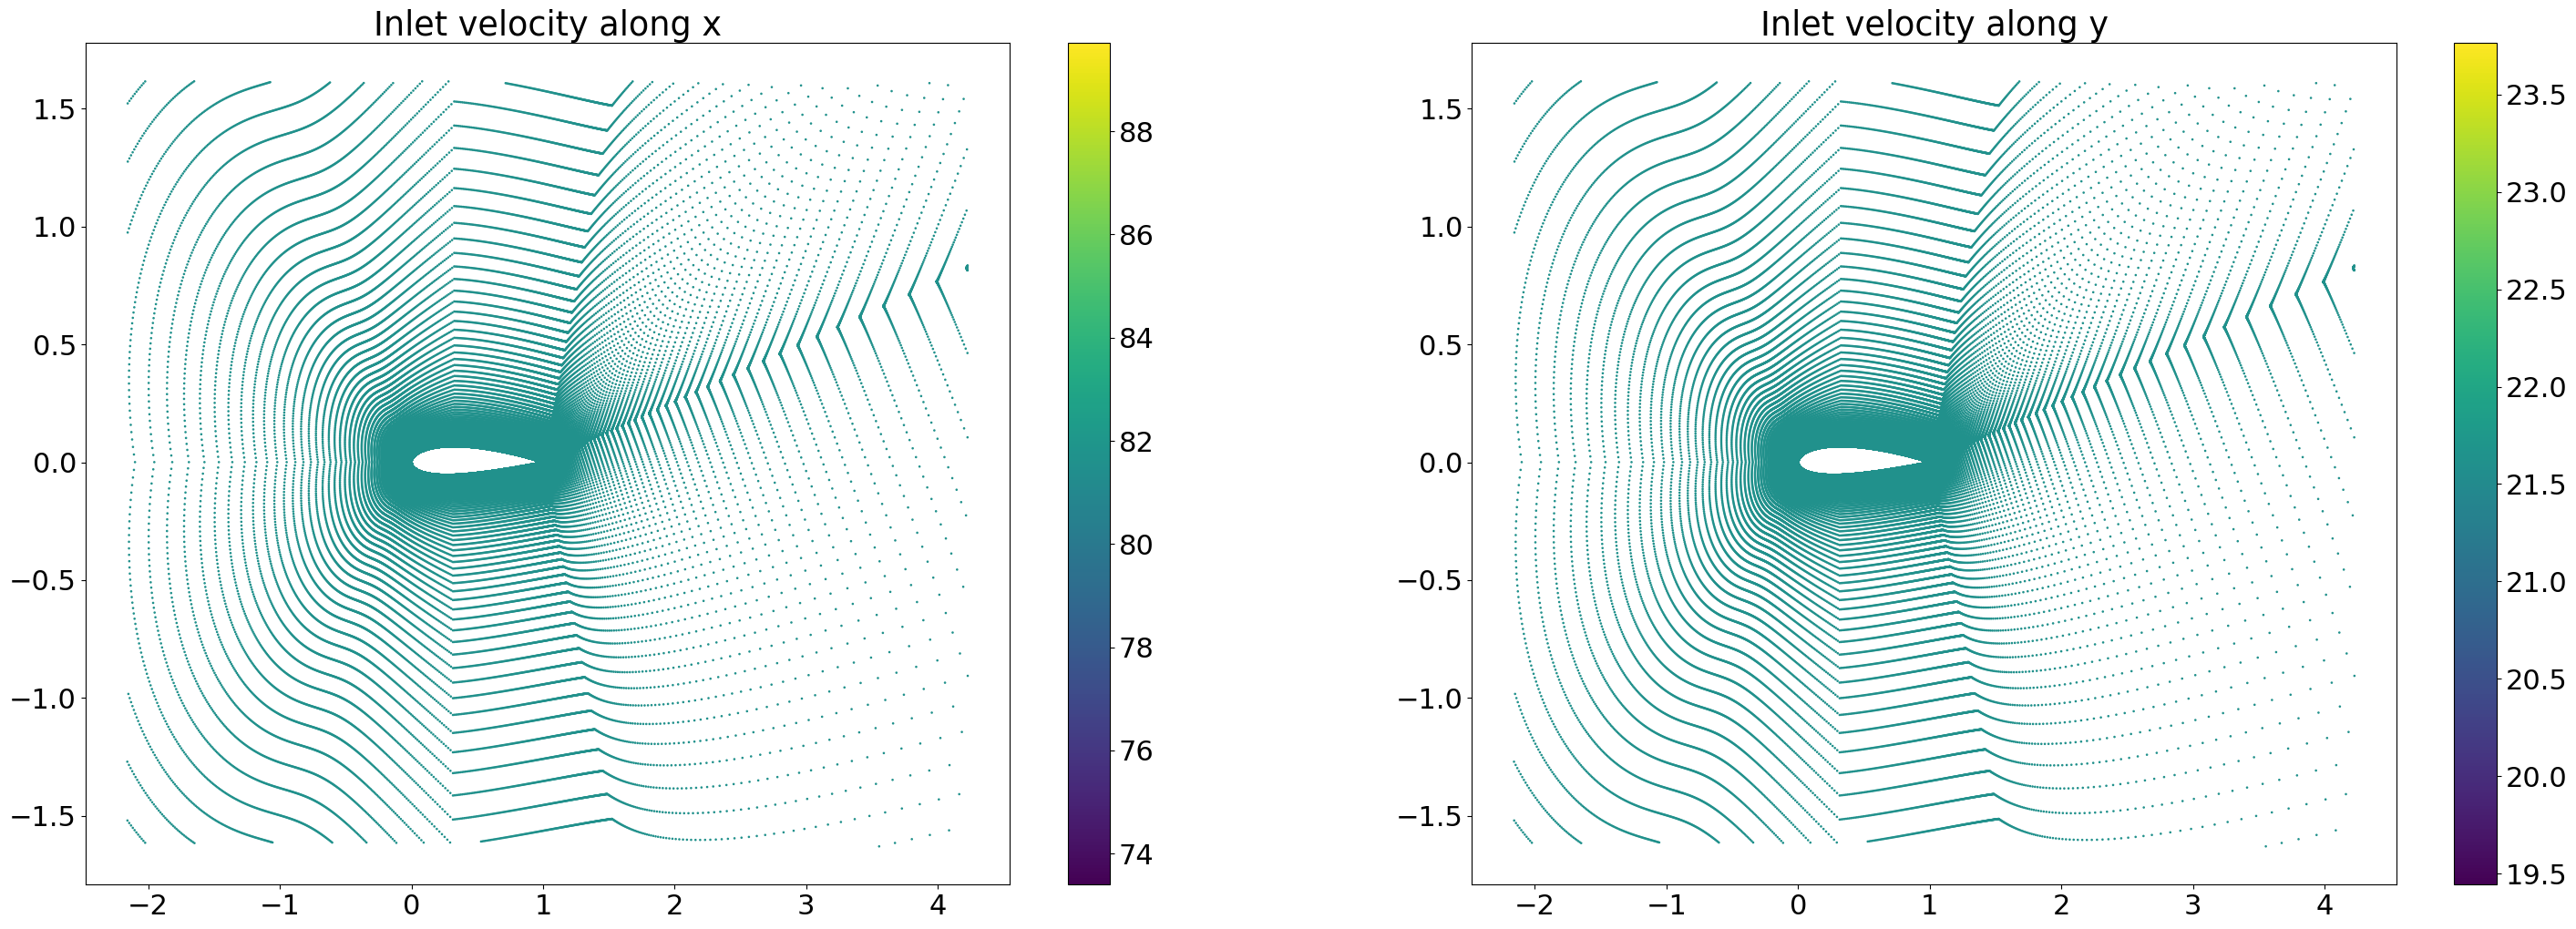

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (36, 12))
sc0 = ax[0].scatter(simulation.position[:, 0], simulation.position[:, 1], c = simulation.input_velocity[:, 0], s = 0.75)
ax[0].title.set_text('Inlet velocity along x')
plt.colorbar(sc0)
sc1 = ax[1].scatter(simulation.position[:, 0], simulation.position[:, 1], c = simulation.input_velocity[:, 1], s = 0.75)
ax[1].title.set_text('Inlet velocity along y')
plt.colorbar(sc1)
plt.show()

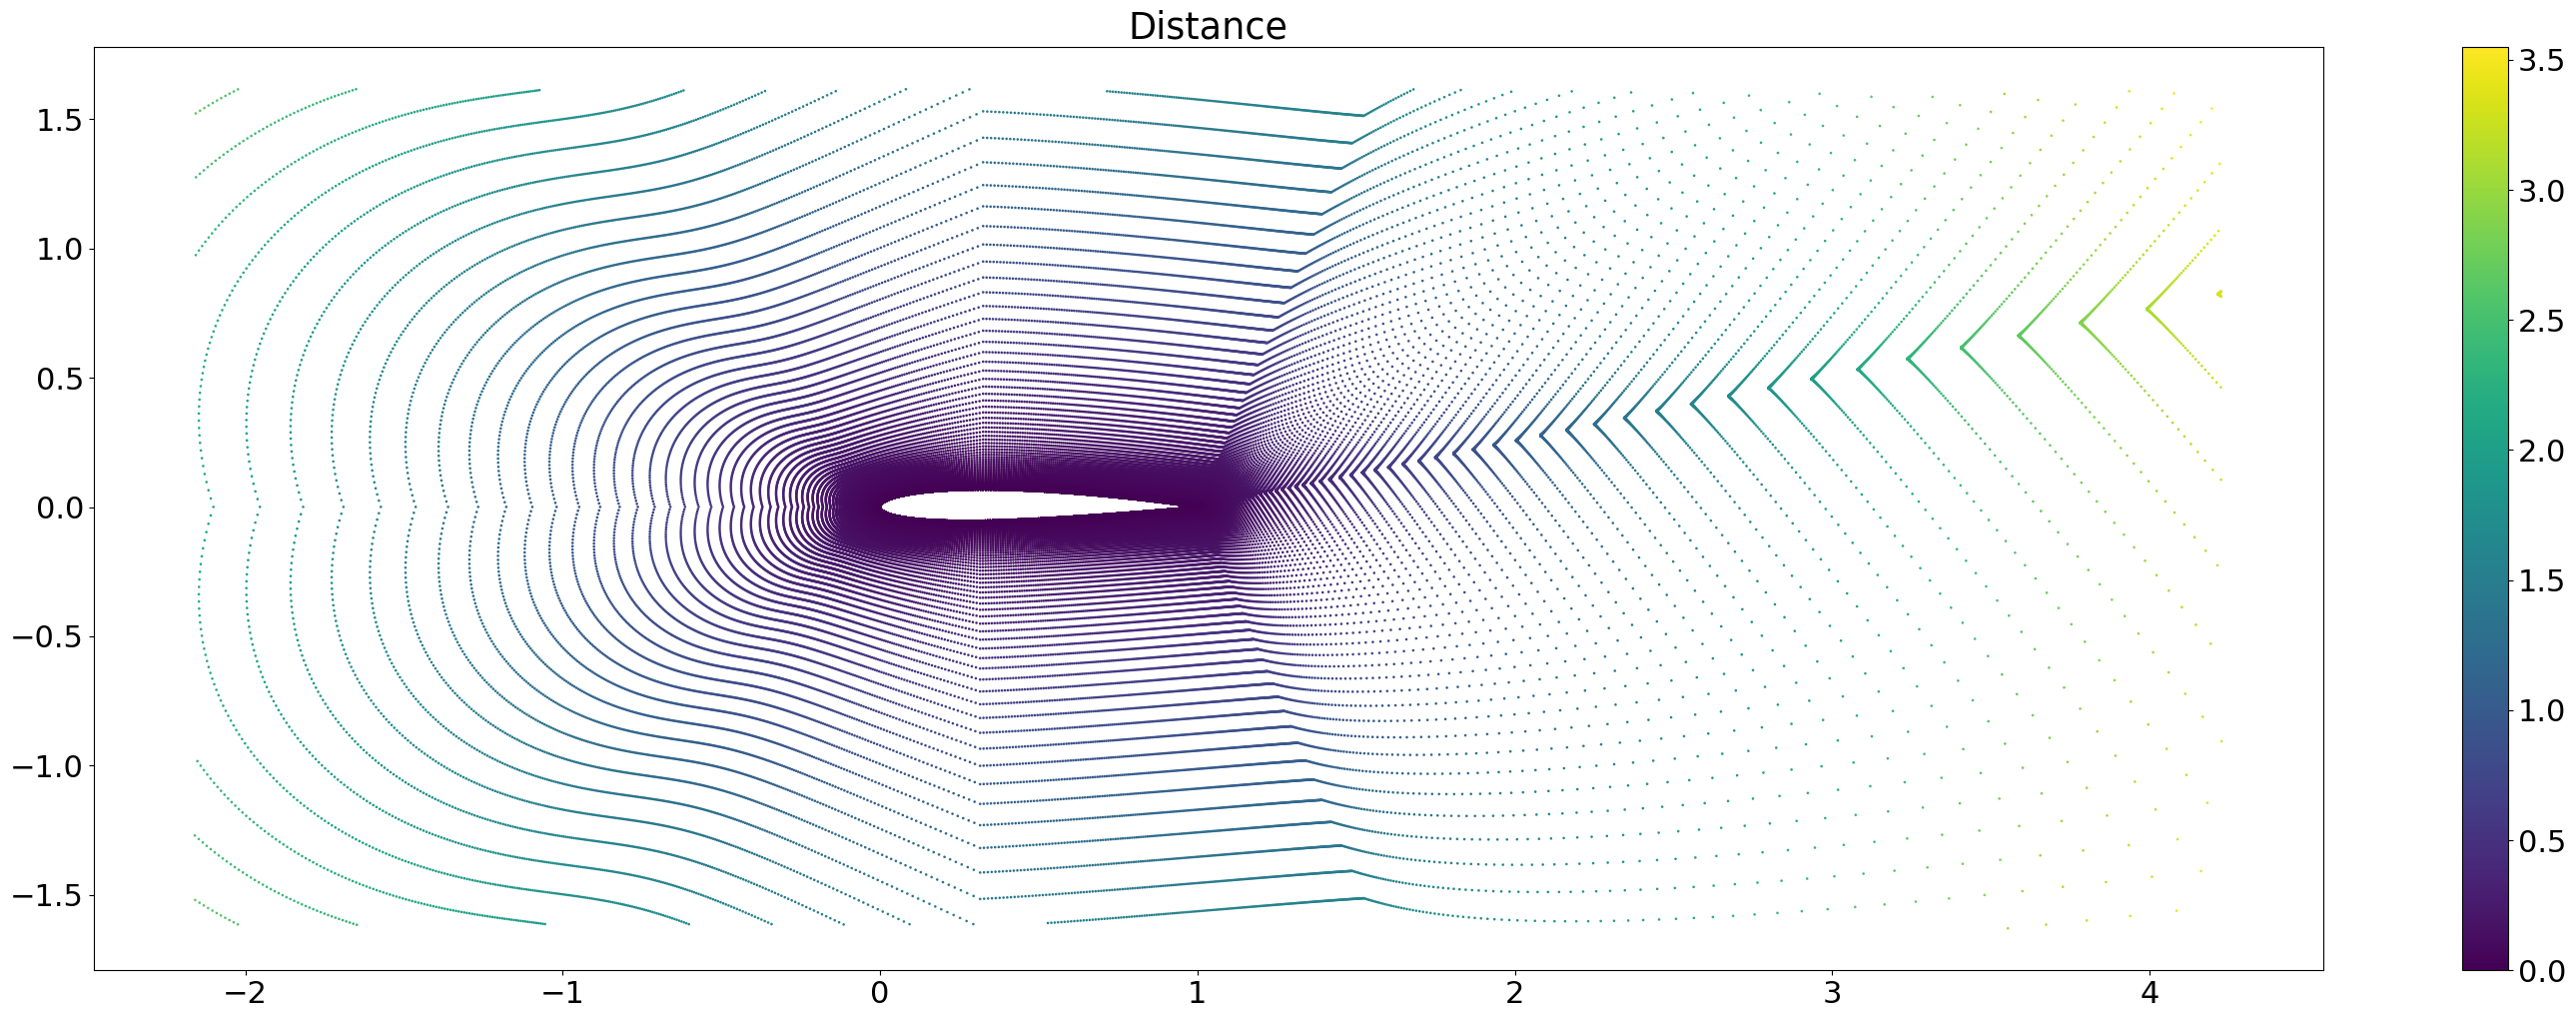

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (36, 12))
sc = ax.scatter(simulation.position[:, 0], simulation.position[:, 1], c = simulation.sdf[:, 0], s = 0.75)
ax.title.set_text('Distance')
plt.colorbar(sc)
plt.show()

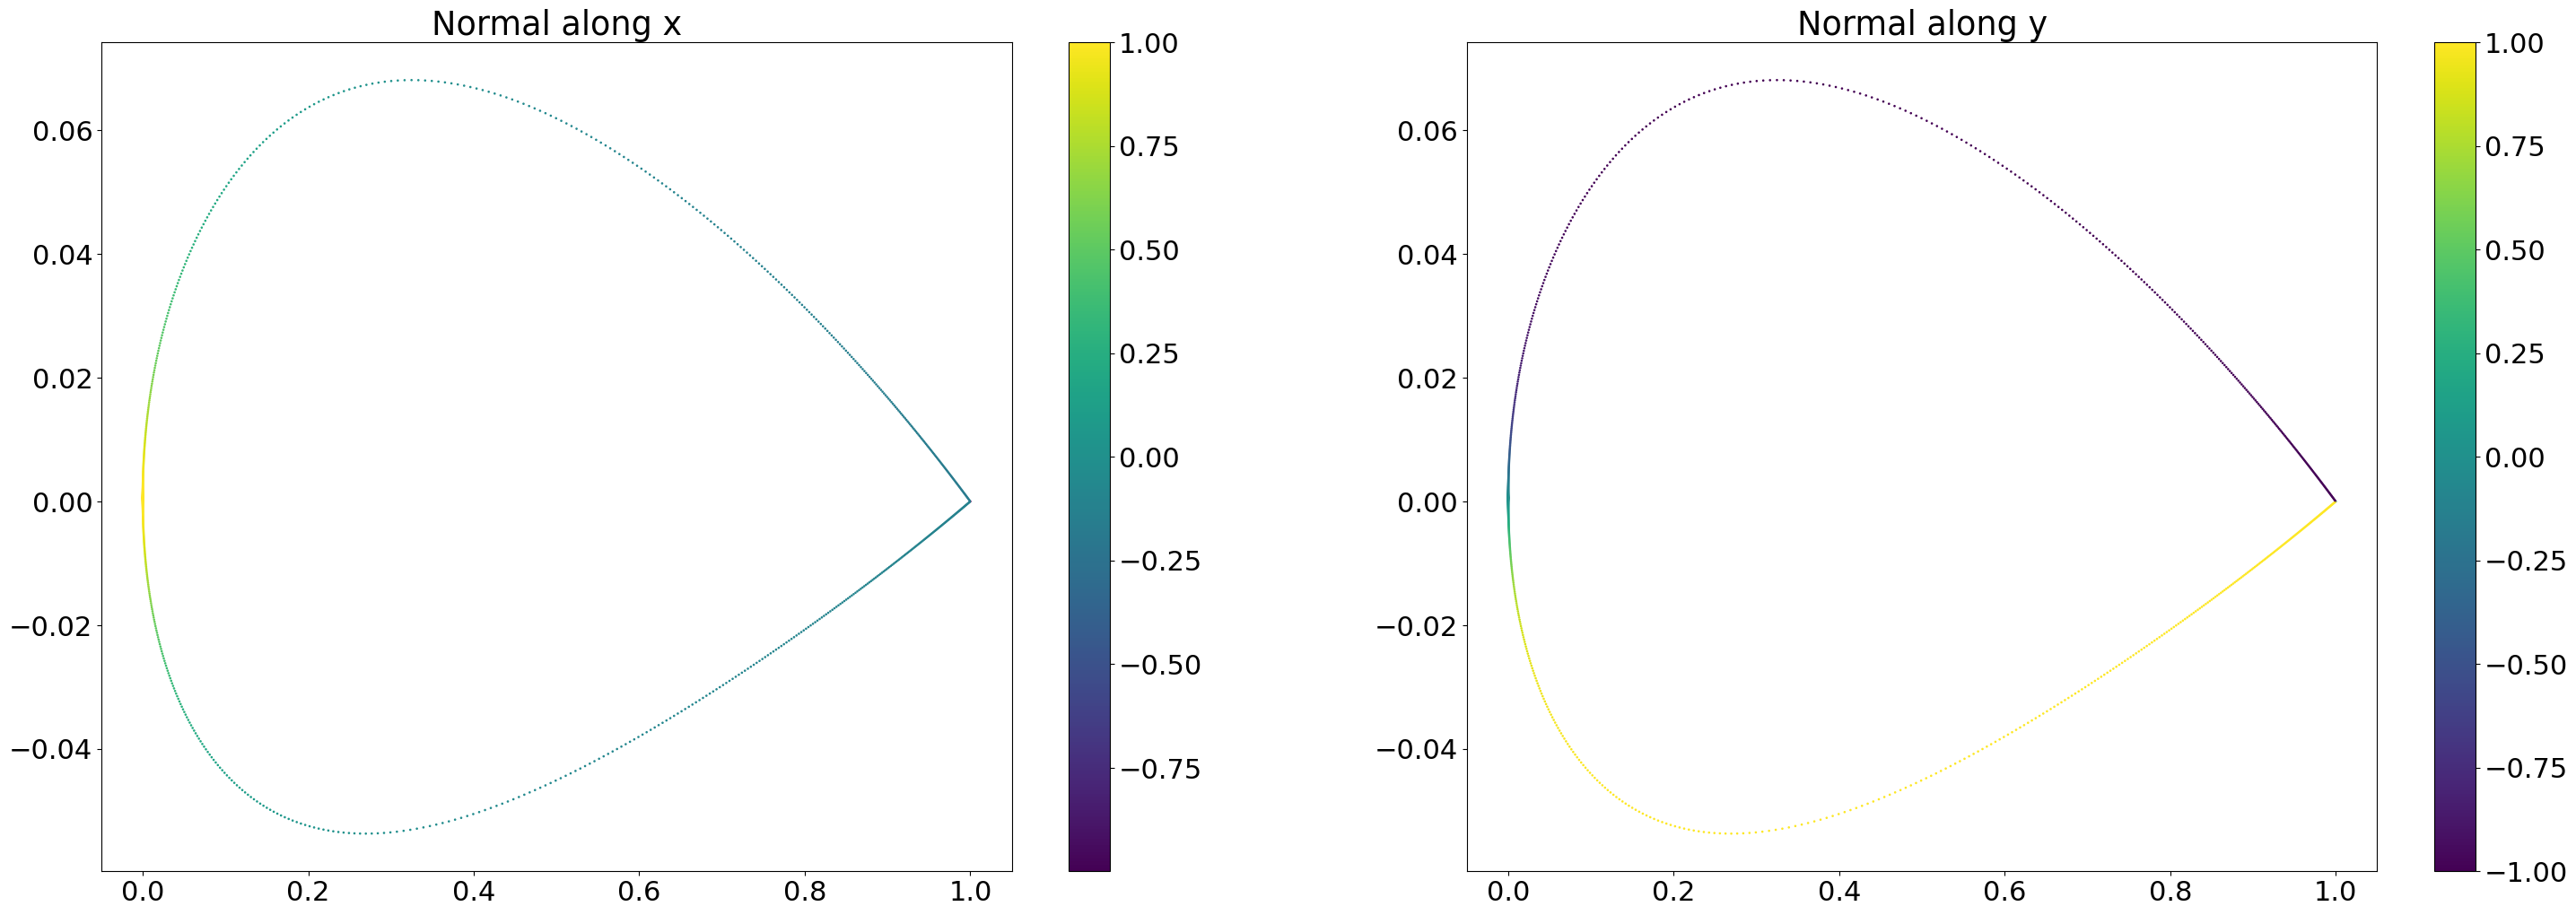

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (36, 12))
sc0 = ax[0].scatter(simulation.airfoil_position[:, 0], simulation.airfoil_position[:, 1], c = simulation.airfoil_normals[:, 0], s = 0.75)
ax[0].title.set_text('Normal along x')
plt.colorbar(sc0)
sc1 = ax[1].scatter(simulation.airfoil_position[:, 0], simulation.airfoil_position[:, 1], c = simulation.airfoil_normals[:, 1], s = 0.75)
ax[1].title.set_text('Normal along y')
plt.colorbar(sc1)
plt.show()

Next, the vizualization of the outputs can also be done easily

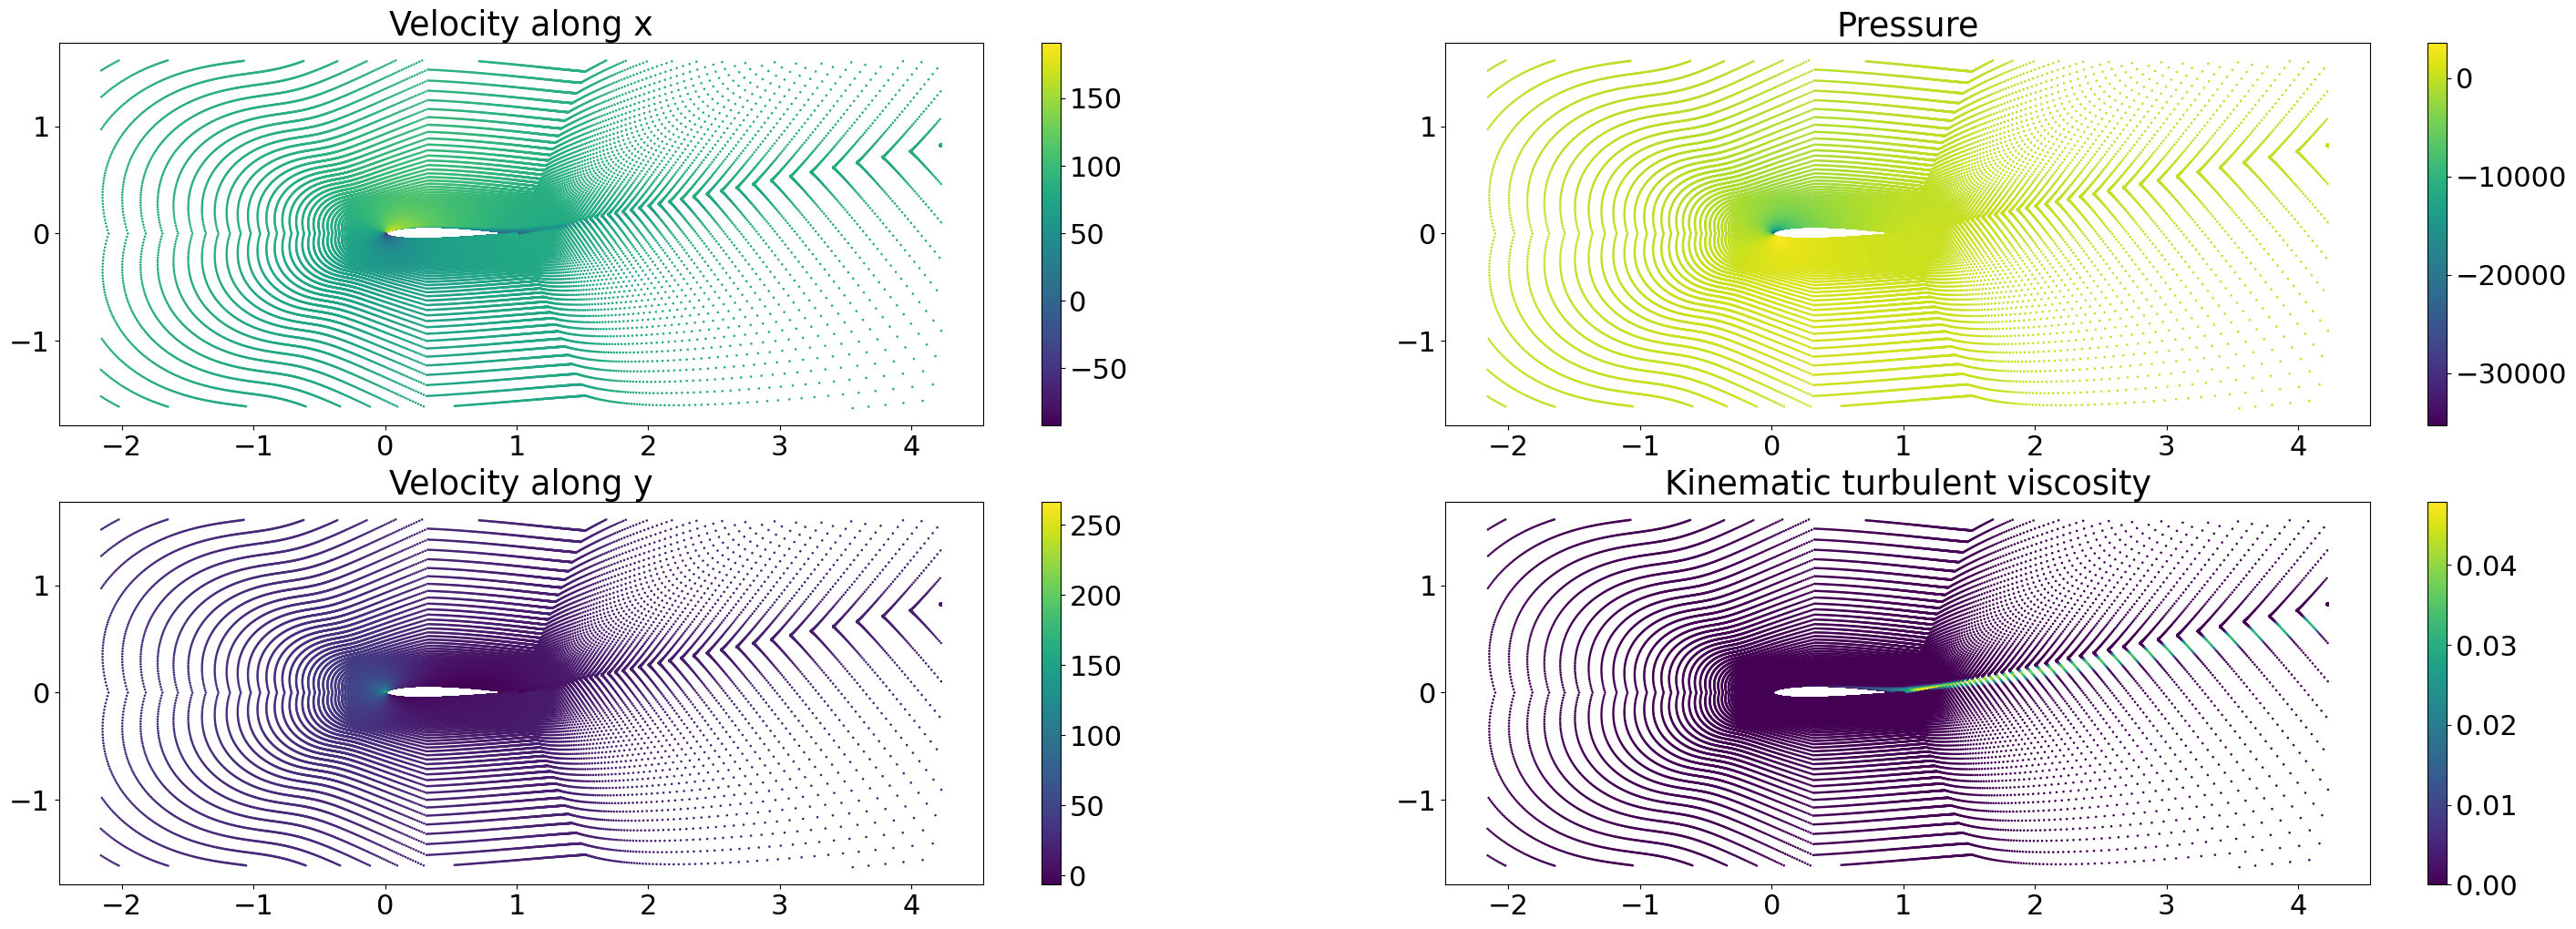

In [ ]:
fig, ax = plt.subplots(2, 2, figsize = (36, 12))
sc0 = ax[0, 0].scatter(simulation.position[:, 0], simulation.position[:, 1], c = simulation.velocity[:, 0], s = 0.75)
ax[0, 0].title.set_text('Velocity along x')
plt.colorbar(sc0)
sc1 = ax[0, 1].scatter(simulation.position[:, 0], simulation.position[:, 1], c = simulation.pressure[:, 0], s = 0.75)
ax[0, 1].title.set_text('Pressure')
plt.colorbar(sc1)
sc2 = ax[1, 0].scatter(simulation.position[:, 0], simulation.position[:, 1], c = simulation.velocity[:, 1], s = 0.75)
ax[1, 0].title.set_text('Velocity along y')
plt.colorbar(sc2)
sc3 = ax[1, 1].scatter(simulation.position[:, 0], simulation.position[:, 1], c = simulation.nu_t[:, 0], s = 0.75)
ax[1, 1].title.set_text('Kinematic turbulent viscosity')
plt.colorbar(sc3)
plt.show()